# American Sign Language Detection

## Data Loading

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
!kaggle datasets download -d ayuraj/asl-dataset

Dataset URL: https://www.kaggle.com/datasets/ayuraj/asl-dataset
License(s): CC0-1.0
 86% 49.0M/56.9M [00:00<00:00, 170MB/s]
100% 56.9M/56.9M [00:00<00:00, 162MB/s]


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('/content/asl-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [18]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [12]:
images = []
labels = []
for subfolder in tqdm(os.listdir('/content/asl_dataset')):
    subfolder_path = os.path.join('/content/asl_dataset', subfolder)
    if not os.path.isdir(subfolder_path) or subfolder=='asl_dataset':
        continue
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 37/37 [00:00<00:00, 4188.42it/s]


image label
0     /content/asl_dataset/3/hand5_3_dif_seg_1_cropp...     3
1     /content/asl_dataset/3/hand3_3_dif_seg_4_cropp...     3
2     /content/asl_dataset/3/hand2_3_dif_seg_2_cropp...     3
3     /content/asl_dataset/3/hand3_3_dif_seg_3_cropp...     3
4     /content/asl_dataset/3/hand1_3_dif_seg_1_cropp...     3
...                                                 ...   ...
2510  /content/asl_dataset/o/hand1_o_dif_seg_3_cropp...     o
2511  /content/asl_dataset/o/hand5_o_dif_seg_1_cropp...     o
2512  /content/asl_dataset/o/hand2_o_bot_seg_2_cropp...     o
2513  /content/asl_dataset/o/hand2_o_right_seg_4_cro...     o
2514  /content/asl_dataset/o/hand2_o_bot_seg_4_cropp...     o

[2515 rows x 2 columns]

In [13]:
df.size

5030

In [14]:
df.shape

(2515, 2)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   2515 non-null   object
 1   label   2515 non-null   object
dtypes: object(2)
memory usage: 39.4+ KB


## Data Visualization

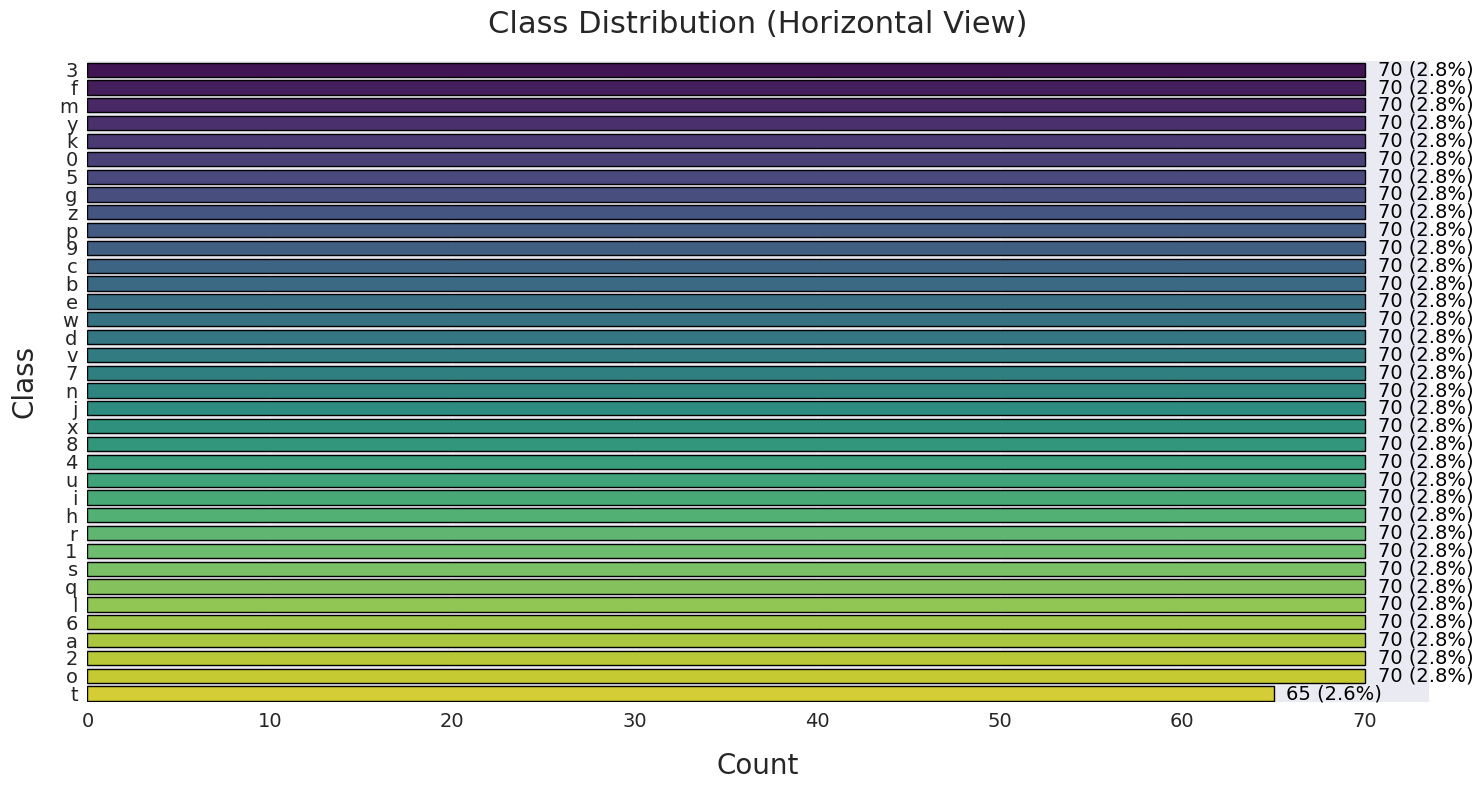

In [22]:
# Plot to analyze total count of different images present in the dataset

sns.set_style("darkgrid")

class_counts = df['label'].value_counts()
plt.figure(figsize=(15, 8))
ax = sns.barplot(
    y=class_counts.index,
    x=class_counts.values,
    palette='viridis',
    edgecolor='black',
    orient='h'
)

ax.set_ylabel("Class", fontsize=20, labelpad=15)
ax.set_xlabel("Count", fontsize=20, labelpad=15)
plt.title('Class Distribution (Horizontal View)', fontsize=22, pad=20)

for i, value in enumerate(class_counts.values):
    percentage = f"{(value / class_counts.sum() * 100):.1f}%"
    ax.text(value + max(class_counts.values) * 0.01, i, f"{value} ({percentage})",
            va='center', fontsize=14, color='black')

plt.grid(axis='x', linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

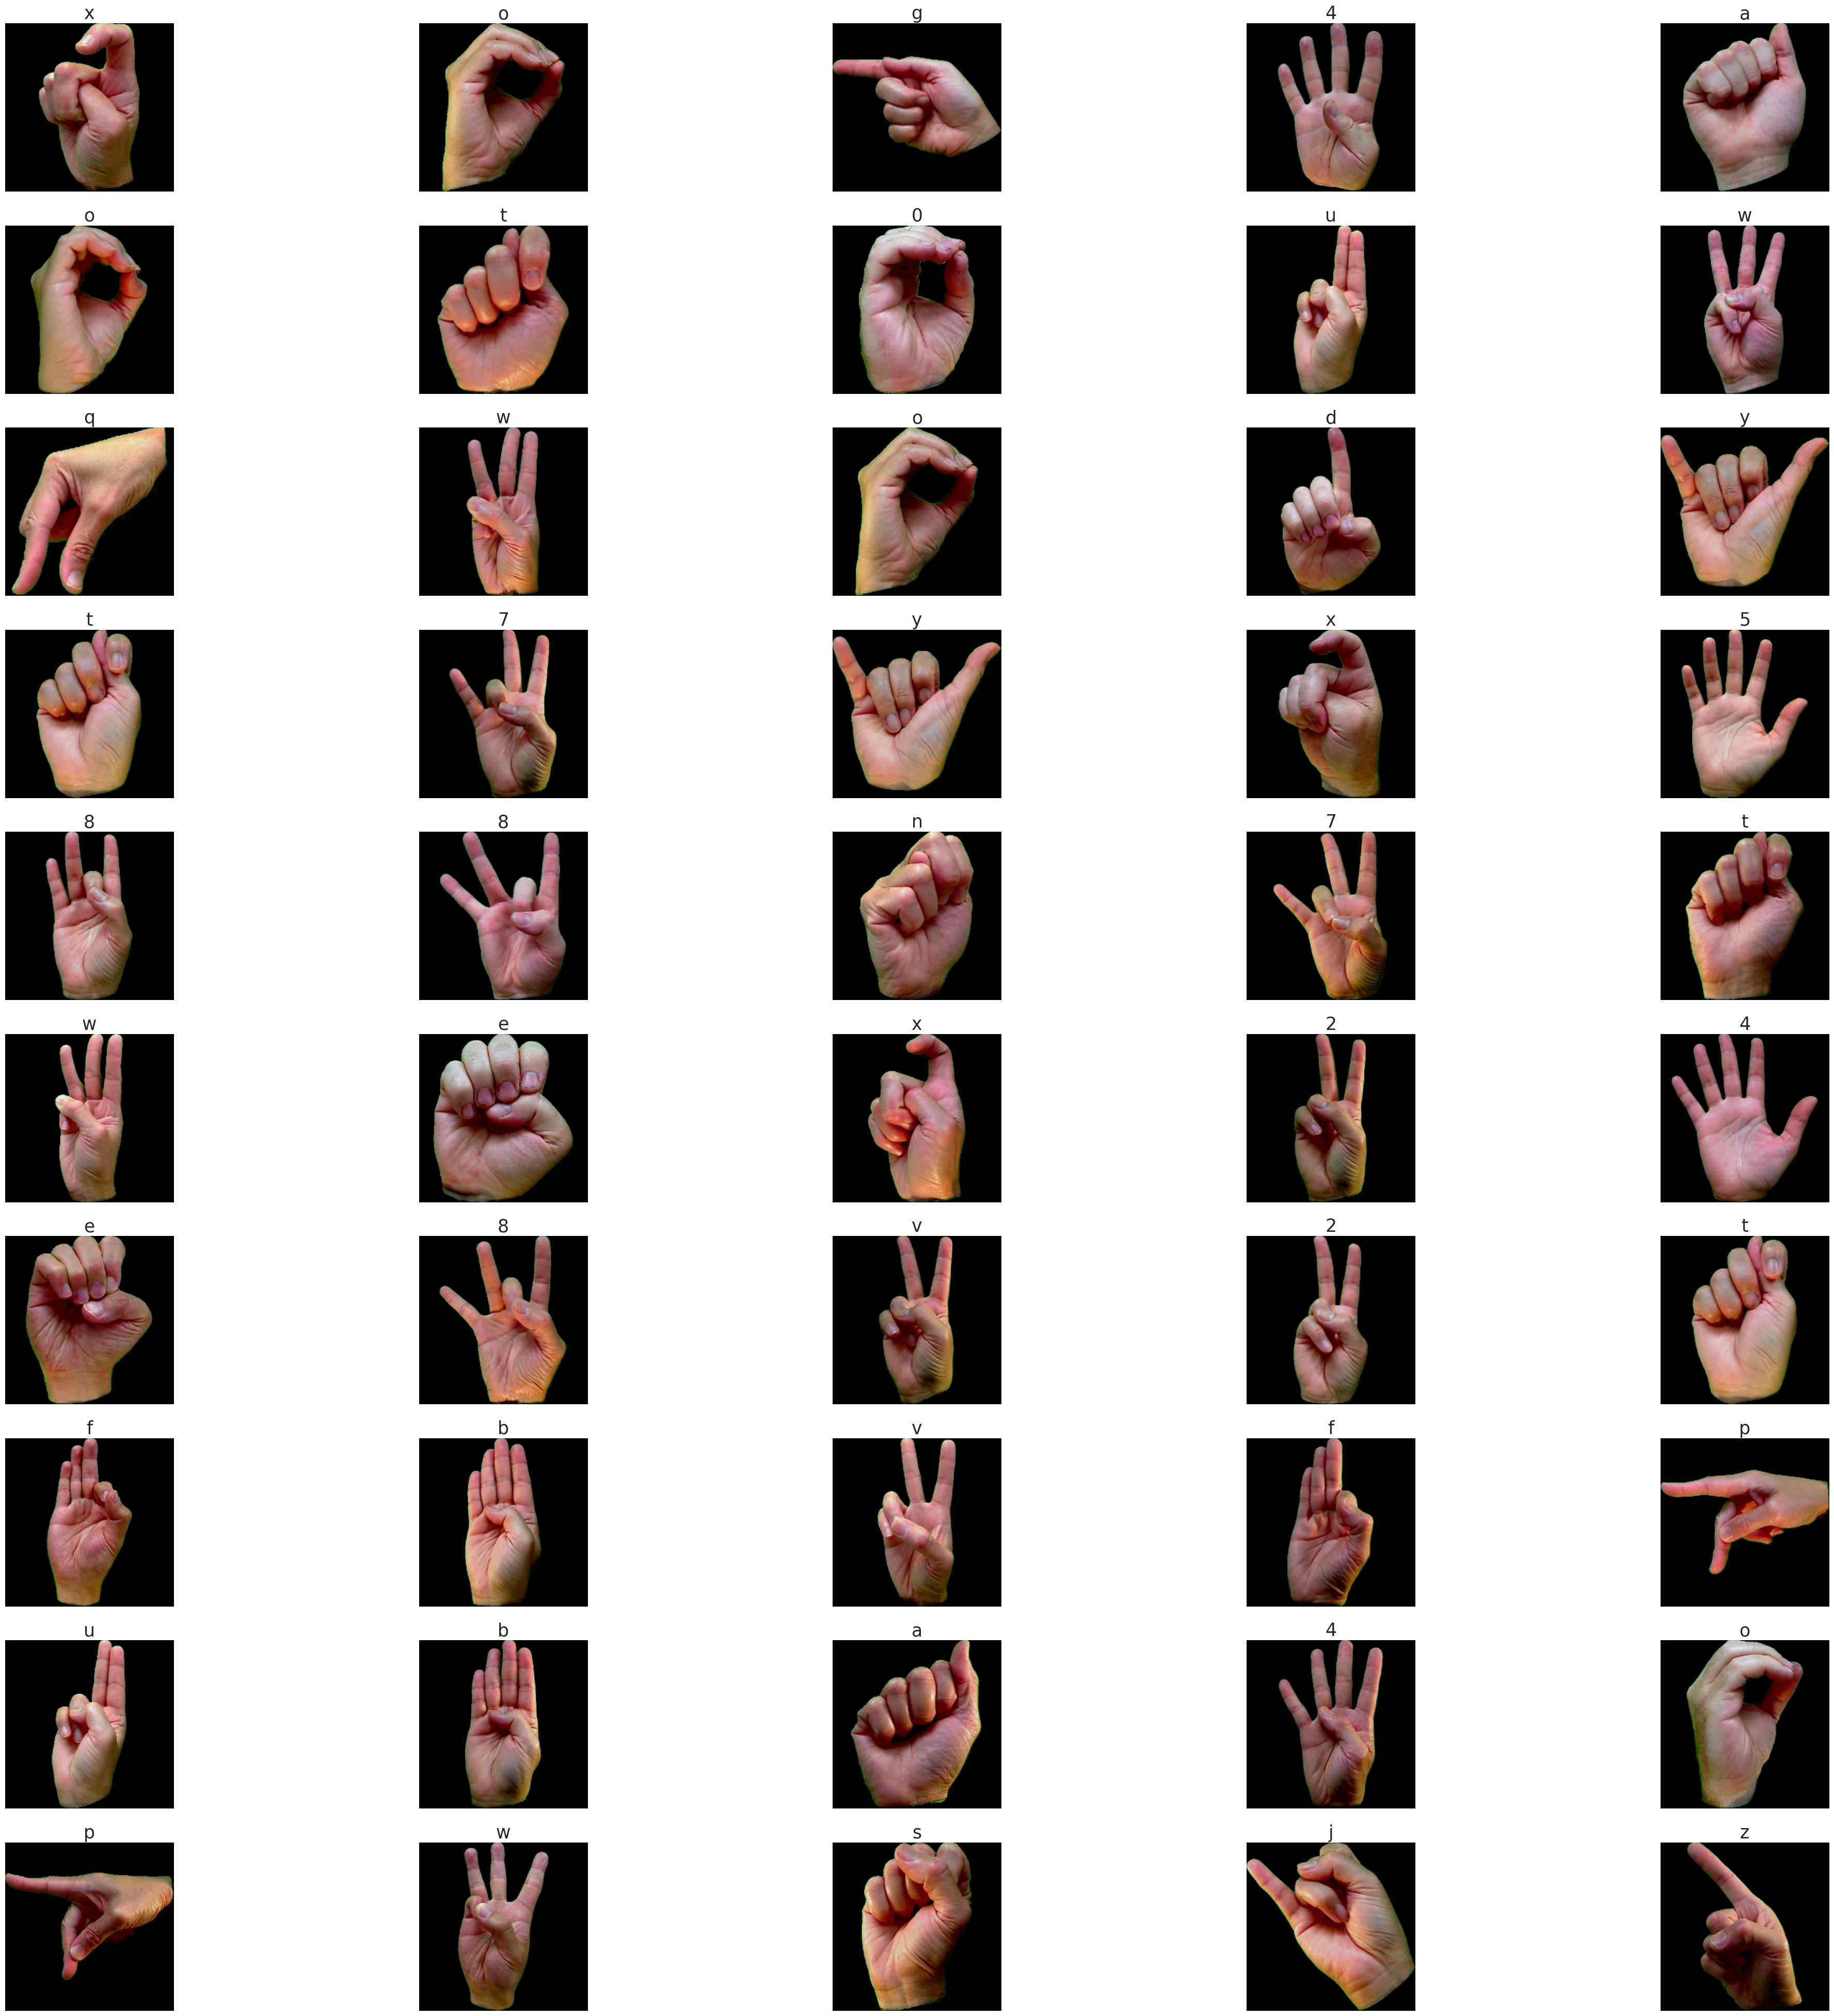

In [23]:
# Plot to visualize the images with labels

plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

## Data Preprocessing

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test1, y_train, y_test1 = train_test_split(df['image'], df['label'], test_size=0.3, random_state=42,shuffle=True,stratify=df['label'])
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)


In [26]:
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})

In [30]:
# Data Augmentation

image_size = (224,224)
batch_size = 32
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)

train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 1760 validated image filenames belonging to 36 classes.
Found 378 validated image filenames belonging to 36 classes.
Found 377 validated image filenames belonging to 36 classes.


## Data Building

### Basic Neural Network

In [87]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [80]:
model = Sequential([

    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),

    Dense(len(train_generator.class_indices), activation='softmax')
])

In [81]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [82]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 36)                  │           2,340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,179,556 (42.65 MB)

 Trainable params: 11,179,556 (42.65 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

Epoch 1/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.1036 - loss: 3.3357 - val_accuracy: 0.5544 - val_loss: 1.4785
Epoch 2/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.4835 - loss: 1.7253 - val_accuracy: 0.7241 - val_loss: 0.8645
Epoch 4/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.6033 - loss: 1.1787 - val_accuracy: 0.8064 - val_loss: 0.6140
Epoch 6/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.7104 - loss: 0.8525 - val_accuracy: 0.8408 - val_loss: 0.4766
Epoch 8/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.7766 - loss: 0.6717 - val_accuracy: 0.8541 - val_lo

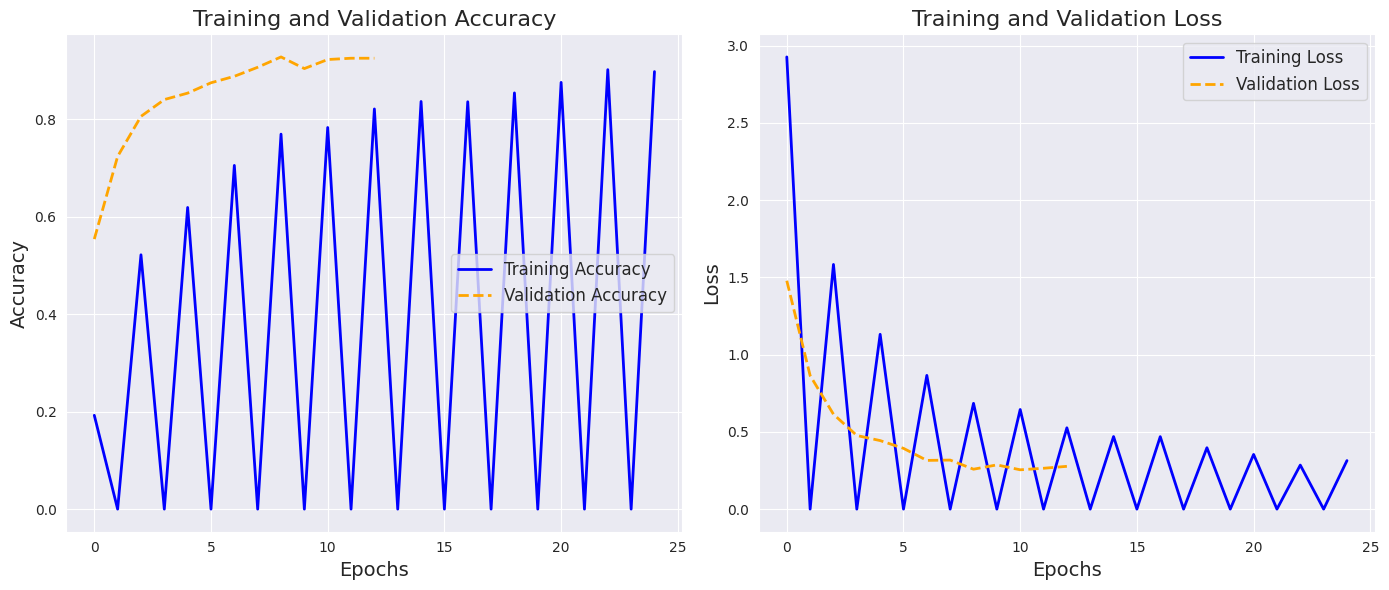

In [84]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy', color='blue', linewidth=2)
    plt.plot(val_acc, label='Validation Accuracy', color='orange', linestyle='--', linewidth=2)
    plt.title('Training and Validation Accuracy', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss', color='blue', linewidth=2)
    plt.plot(val_loss, label='Validation Loss', color='orange', linestyle='--', linewidth=2)
    plt.title('Training and Validation Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [85]:
score, acc= model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.9408 - loss: 0.2277
Test Loss = 0.1585751473903656
Test Accuracy = 0.9523809552192688


In [86]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


Actual  Prediction
0        17          17
1        29          29
2         0           0
3         6           6
4        11          15
..      ...         ...
373      30          30
374      35          35
375      10          10
376      20          20
377       9           9

[378 rows x 2 columns]

array([[ 7,  0,  0, ...,  0,  0,  0],
       [ 0, 11,  0, ...,  0,  0,  0],
       [ 0,  0, 11, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 11,  0,  0],
       [ 0,  0,  0, ...,  0, 10,  0],
       [ 0,  0,  0, ...,  0,  0, 11]])

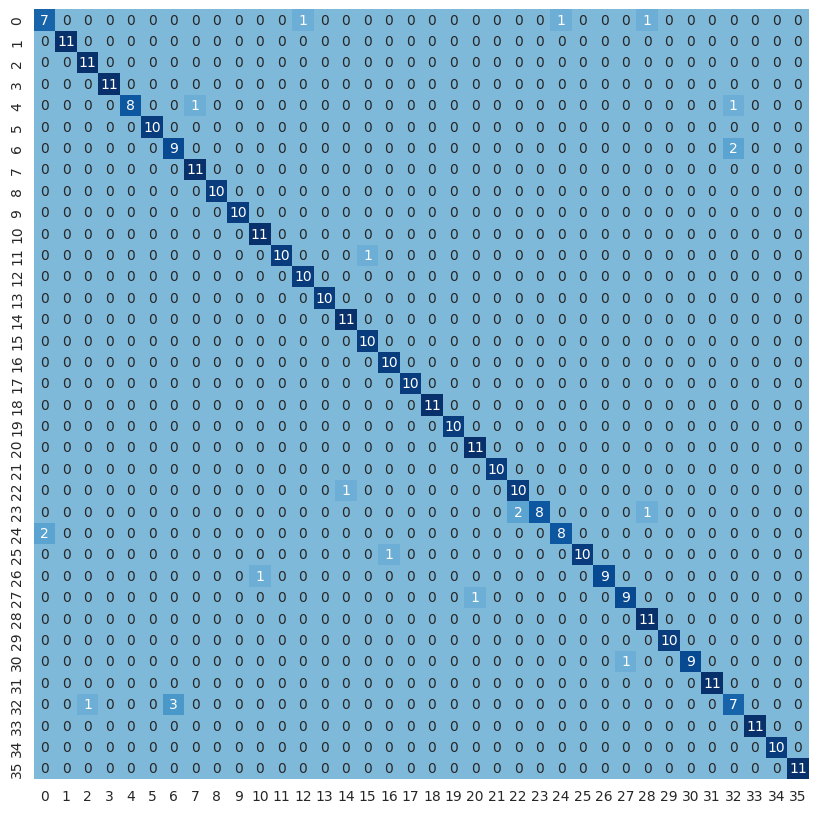

In [88]:
plt.figure(figsize=(10,10))
CM = confusion_matrix(y_test,y_pred)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

### Neural Network using VGG16

In [89]:
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [90]:
model = keras.models.Sequential([
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(36, activation=tf.nn.softmax)
])

In [91]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 36)                  │           9,252 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,146,724 (80.67 MB)

 Trainable params: 6,432,036 (24.54 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [92]:
hist = model.fit(train_generator, epochs=20, validation_data=val_generator)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 40s 436ms/step - accuracy: 0.1818 - loss: 3.8619 - val_accuracy: 0.7135 - val_loss: 1.0219
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.6615 - loss: 1.1342 - val_accuracy: 0.8912 - val_loss: 0.4763
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.8188 - loss: 0.6126 - val_accuracy: 0.9310 - val_loss: 0.2884
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.8837 - loss: 0.4020 - val_accuracy: 0.9231 - val_loss: 0.2547
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.8963 - loss: 0.3756 - val_accuracy: 0.9416 - val_loss: 0.1799
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.9150 - loss: 0.2802 - val_accuracy: 0.9469 - val_loss: 0.1463
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.9319 - loss: 0.2088 - val_accuracy: 0.9549 - val_loss: 0.1343
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.9505 - loss: 0.1686 - val_accurac

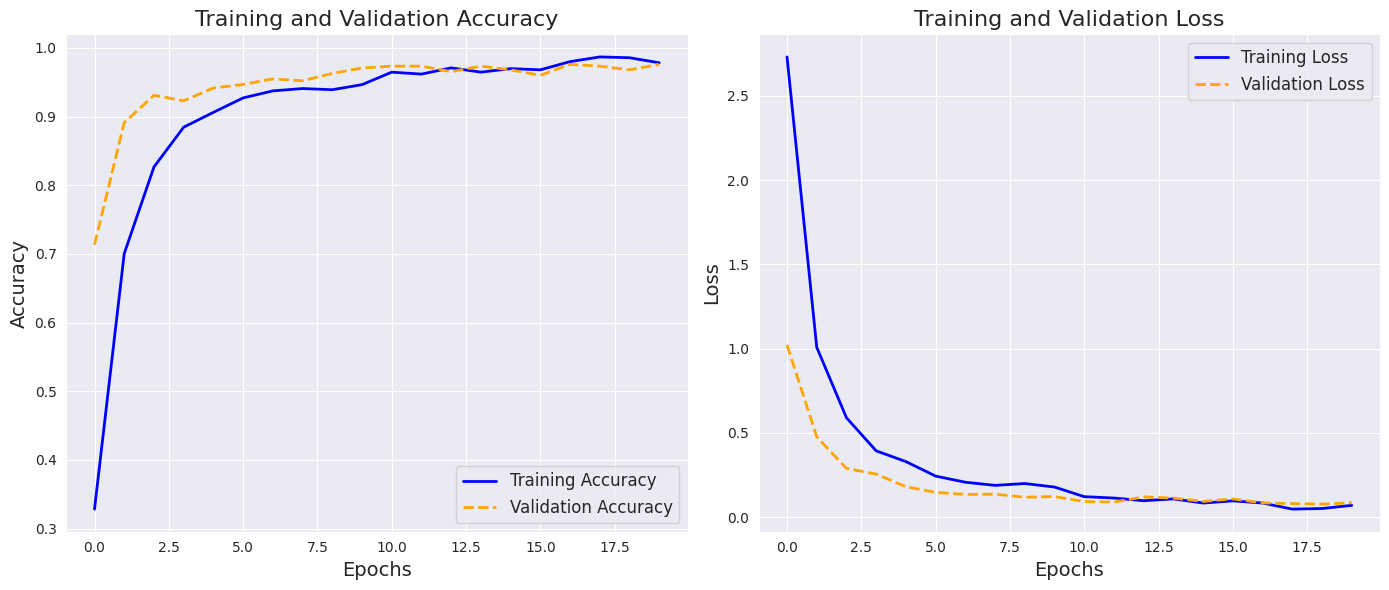

In [94]:
def plot_training_history(history):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy', color='blue', linewidth=2)
    plt.plot(val_acc, label='Validation Accuracy', color='orange', linestyle='--', linewidth=2)
    plt.title('Training and Validation Accuracy', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss', color='blue', linewidth=2)
    plt.plot(val_loss, label='Validation Loss', color='orange', linestyle='--', linewidth=2)
    plt.title('Training and Validation Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [95]:
score, acc= model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)

12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9823 - loss: 0.0533
Test Loss = 0.04635168984532356
Test Accuracy = 0.9841269850730896


In [96]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step


Actual  Prediction
0        17          17
1        29          29
2         0          24
3         6           6
4        11          11
..      ...         ...
373      30          30
374      35          13
375      10          10
376      20          20
377       9           9

[378 rows x 2 columns]

array([[ 9,  0,  0, ...,  0,  0,  0],
       [ 0, 11,  0, ...,  0,  0,  0],
       [ 0,  0, 11, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 11,  0,  0],
       [ 0,  0,  0, ...,  0, 10,  0],
       [ 0,  0,  0, ...,  0,  0, 10]])

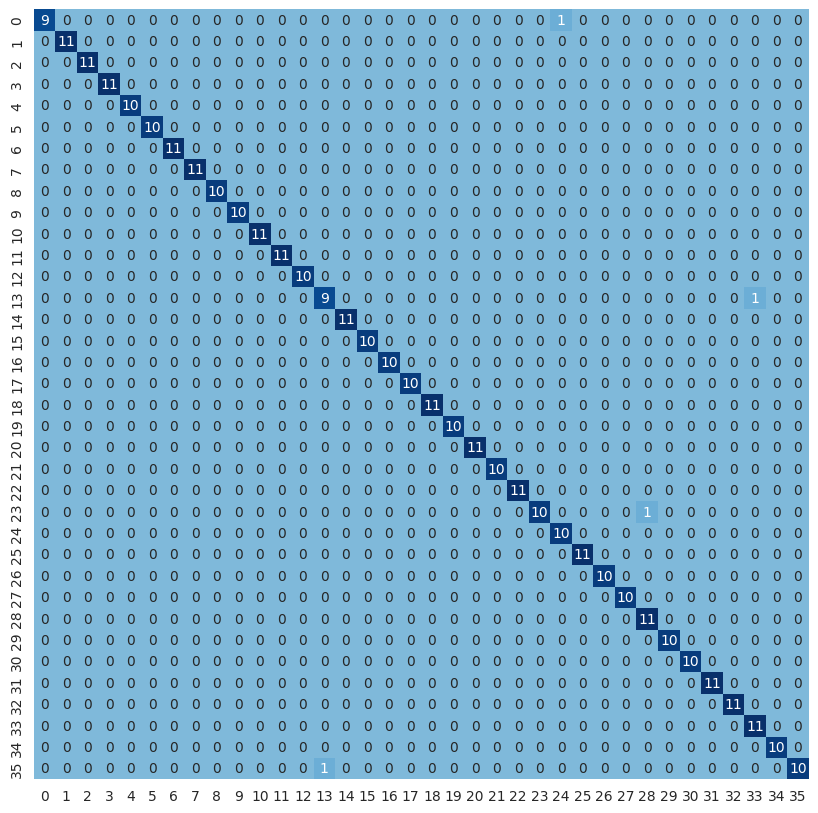

In [97]:
plt.figure(figsize=(10,10))
CM = confusion_matrix(y_test,y_pred)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

Neural Network using InceptionV3

In [109]:
base_model = tf.keras.applications.InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

In [110]:
model = keras.models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(36, activation='softmax')
])

In [111]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 36)                  │           9,252 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,336,580 (85.21 MB)

 Trainable params: 533,796 (2.04 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [112]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [113]:
history_InceptionV3 = model.fit(train_generator, epochs=25, validation_data=val_generator)

Epoch 1/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 25s 240ms/step - accuracy: 0.1688 - loss: 3.2457 - val_accuracy: 0.6180 - val_loss: 1.6360
Epoch 2/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.5459 - loss: 1.6170 - val_accuracy: 0.7162 - val_loss: 1.0560
Epoch 3/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.6625 - loss: 1.1643 - val_accuracy: 0.8011 - val_loss: 0.7786
Epoch 4/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.7490 - loss: 0.8384 - val_accuracy: 0.8037 - val_loss: 0.6329
Epoch 5/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.8168 - loss: 0.6145 - val_accuracy: 0.8568 - val_loss: 0.5285
Epoch 6/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.8558 - loss: 0.5137 - val_accuracy: 0.8647 - val_loss: 0.5066
Epoch 7/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.8614 - loss: 0.4964 - val_accuracy: 0.8700 - val_loss: 0.4076
Epoch 8/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.8816 - loss: 0.3780 - val_accuracy: 0.8

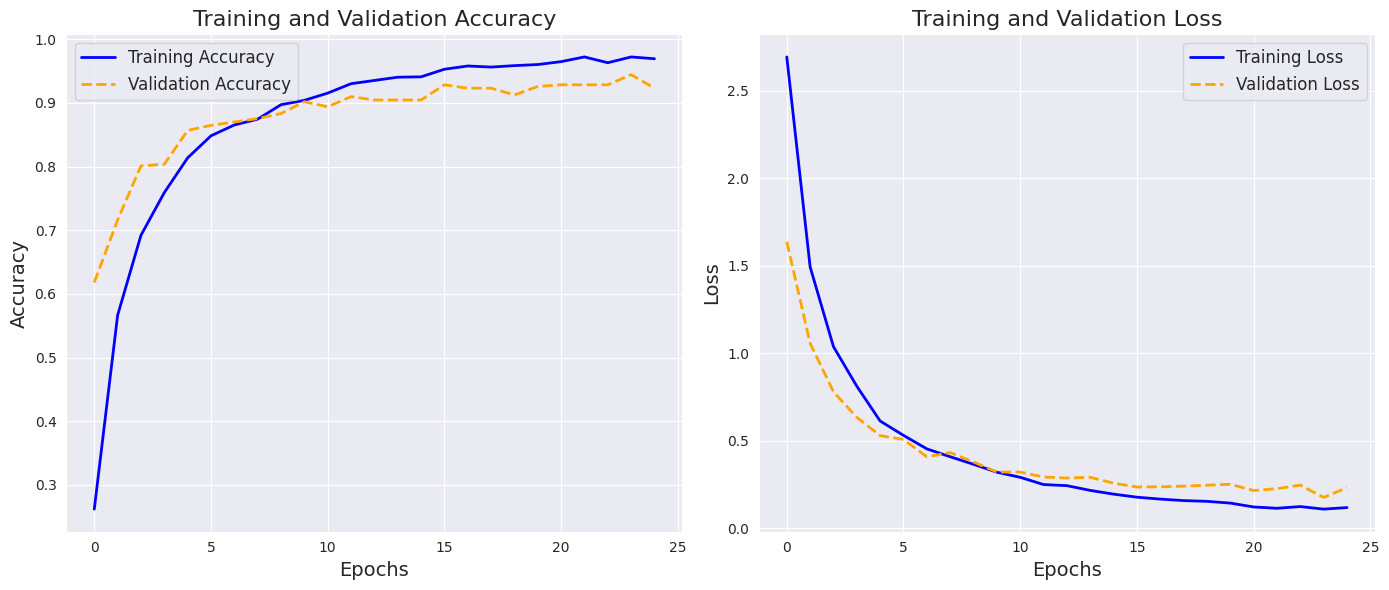

In [114]:
def plot_training_history(history):
    acc = history_InceptionV3.history['accuracy']
    val_acc = history_InceptionV3.history['val_accuracy']
    loss = history_InceptionV3.history['loss']
    val_loss = history_InceptionV3.history['val_loss']

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy', color='blue', linewidth=2)
    plt.plot(val_acc, label='Validation Accuracy', color='orange', linestyle='--', linewidth=2)
    plt.title('Training and Validation Accuracy', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss', color='blue', linewidth=2)
    plt.plot(val_loss, label='Validation Loss', color='orange', linestyle='--', linewidth=2)
    plt.title('Training and Validation Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [115]:
score, acc= model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)

12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 795ms/step - accuracy: 0.9222 - loss: 0.1842
Test Loss = 0.18184980750083923
Test Accuracy = 0.9285714030265808


In [116]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 523ms/step


Actual  Prediction
0        17          17
1        29          29
2         0          24
3         6           6
4        11          11
..      ...         ...
373      30          30
374      35          35
375      10          29
376      20          20
377       9           9

[378 rows x 2 columns]

array([[ 9,  0,  0, ...,  0,  0,  0],
       [ 0, 10,  0, ...,  0,  0,  0],
       [ 0,  0,  8, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 11,  0,  0],
       [ 0,  0,  0, ...,  0, 10,  0],
       [ 0,  0,  0, ...,  0,  0, 11]])

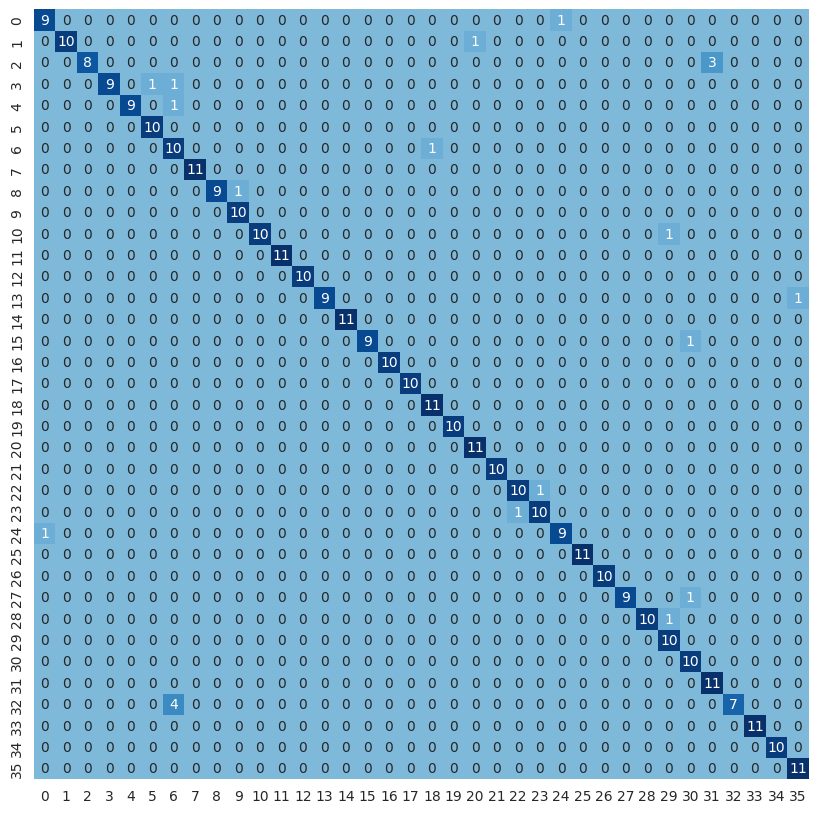

In [117]:
plt.figure(figsize=(10,10))
CM = confusion_matrix(y_test,y_pred)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM